# Sentiment Classifier for Rotten Tomatoes Movie Reviews

## III. Modeling

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('dark_background')
plt.style.use(style="seaborn")
%matplotlib inline

# Import custom preprocessing functions
import sys
sys.path.insert(0, 'modules/')
from data_preprocessing import *

# NLP
from nltk.tokenize import word_tokenize
import nltk

# For splitting the data
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For building the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonas.MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jonas.MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We can load the cleaned data from the previous section.

In [2]:
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final-project/data/rotten_tomatoes/reviews_clean.csv', encoding='utf-8')
reviews = pd.read_csv('../data/rotten_tomatoes/reviews_clean.csv', encoding='utf-8')


In [16]:
reviews

,Text,Type
0,fantasy adventure fuse greek mythology contemp...,1
1,uma thurman medusa gorgon coiffure writhing sn...,1
2,topnotch cast dazzling special effect tide tee...,1
3,whether audience get behind lightning thief ha...,1
4,really lacking lightning thief genuine sense w...,0
...,...,...
949176,rousing reconstruction 1879 battle rorkes drift,1
949177,seen today startling indictment british imperi...,1
949178,rousing visual spectacle prequel cy endfield d...,1
949179,simple twoact story prelude war war former con...,0


In [6]:
reviews['Text']

0         fantasy adventure fuse greek mythology contemp...
1         uma thurman medusa gorgon coiffure writhing sn...
2         topnotch cast dazzling special effect tide tee...
3         whether audience get behind lightning thief ha...
4         really lacking lightning thief genuine sense w...
                                ...                        
949176      rousing reconstruction 1879 battle rorkes drift
949177    seen today startling indictment british imperi...
949178    rousing visual spectacle prequel cy endfield d...
949179    simple twoact story prelude war war former con...
949180    ride line pure artifact bygone eraone depicts ...
Name: Text, Length: 949181, dtype: object

### Embeddings

#### Using GloVe

[GloVe](https://nlp.stanford.edu/projects/glove/) is an unsupervised learning algorithm for obtaining vectorizing words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. The main intuition underlying the model is the simple observation that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning.

The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence.

We are going to use a 300D variation of GloVe pretrained corpus model to represent our words.

Let's make sure that the `Text` column values are of type *str* 

In [9]:
reviews['Text'] = reviews['Text'].astype('str')

In [10]:
corpus = create_corpus(reviews)

In [17]:
num_words = len(corpus)
print(num_words)

949181


In [18]:
corpus[0]

['fantasy',
 'adventure',
 'fuse',
 'greek',
 'mythology',
 'contemporary',
 'american',
 'place',
 'value',
 'anyone',
 'around',
 '15',
 'give',
 'take',
 'couple',
 'year',
 'thrill',
 'visual',
 'spectacle']

Train / test split

In [ ]:
X = reviews.iloc[:,:-1]
y = reviews.iloc[:,-1]

In [ ]:
train_size = int(reviews.shape[0] * 0.7)

In [ ]:
train_size

664426

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#train_sentences = train.text[:train_size]
#train_labels = train.target[:train_size]

#test_sentences = train.text[train_size:]
#test_labels = train.target[train_size:]


train_sentences = X_train['Text']
train_labels = y_train

test_sentences = X_test['Text']
test_labels = y_test

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

In [ ]:
# https://stackoverflow.com/questions/69026891/what-is-keras-tokenizer-fit-on-texts-doing
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
train_sentences

796377    crossdressing lead hissable villain oodles dou...
970672    dalsgaards advocacy gehls utopian vision large...
222744    gains huge points working standalone movie set...
608786    sadly could next tiny furniture gets wrapped n...
521067    antideath penalty nature film lauded lacks imp...
                                ...                        
280317    comedy favors mania wit requires high toleranc...
393908          film endures largely appeal story line cast
144874    part response stanley kubricks heady masterpie...
776804                    heart humour countdown armageddon
134392    marital crisis movies heart lost allegorical w...
Name: Text, Length: 664426, dtype: object

In [ ]:
train_sequences

[[17940,
  359,
  28033,
  1708,
  15608,
  1739,
  28034,
  6983,
  3624,
  276,
  2865,
  4504,
  27,
  180,
  79,
  108,
  14373,
  34,
  1173,
  1526,
  3749],
 [86610,
  12880,
  86611,
  17161,
  588,
  682,
  8809,
  12748,
  2151,
  51529,
  1,
  1594,
  47100,
  47101,
  13256,
  26420,
  86612,
  28035,
  3287],
 [6776,
  1300,
  651,
  676,
  5812,
  2,
  170,
  61,
  3518,
  61,
  799,
  340,
  19,
  788,
  671,
  20,
  2117,
  51530,
  124,
  143,
  4204,
  237,
  3006,
  86],
 [1075, 42, 315, 2753, 11426, 122, 2350, 8103, 514, 615, 332, 9252],
 [57723, 13009, 416, 1, 15609, 311, 748, 1682, 231, 5],
 [177, 16, 3956, 16, 6548, 357, 2187, 230, 728, 493],
 [57724, 521, 2736, 78],
 [24430, 148, 11427, 67588, 1654, 1163, 4770, 840],
 [633, 61, 1013, 506, 2833, 602, 80, 264, 310, 678, 1804],
 [832,
  660,
  3625,
  1692,
  5484,
  732,
  36,
  1428,
  21338,
  605,
  928,
  1800,
  135,
  4,
  69,
  1588,
  326,
  1218],
 [5003,
  648,
  5605,
  39,
  579,
  19,
  1219,
  1002,


In [ ]:
train_padded = pad_sequences(
    train_sequences, maxlen=max_len, truncating="post", padding="post"
)

In [ ]:
train_padded

array([[17940,   359, 28033, ...,     0,     0,     0],
       [86610, 12880, 86611, ...,     0,     0,     0],
       [ 6776,  1300,   651, ...,     0,     0,     0],
       ...,
       [  137,  3772,  4313, ...,     0,     0,     0],
       [  105,   632, 13110, ...,     0,     0,     0],
       [ 6753,  1616,    20, ...,     0,     0,     0]], dtype=int32)

In [ ]:
train_padded[0]

array([17940,   359, 28033,  1708, 15608,  1739, 28034,  6983,  3624,
         276,  2865,  4504,    27,   180,    79,   108, 14373,    34,
        1173,  1526,  3749,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

In [ ]:
test_padded

array([[  215,   361,    18, ...,     0,     0,     0],
       [   88,     2,  6003, ...,     0,     0,     0],
       [   80,  1763, 20027, ...,     0,     0,     0],
       ...,
       [  521,  8444,   325, ...,     0,     0,     0],
       [    3,  1237,   227, ...,     0,     0,     0],
       [  214,  3662,  1175, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print(X_train['Text'].iloc[0])
print(train_sequences[0])

crossdressing lead hissable villain oodles double entendre sherlock holmes game shadows closest action cinema ever come pantomime thats meant sincere compliment
[17940, 359, 28033, 1708, 15608, 1739, 28034, 6983, 3624, 276, 2865, 4504, 27, 180, 79, 108, 14373, 34, 1173, 1526, 3749]


In [ ]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 182057


In [ ]:
word_index

{'film': 1,
 'movie': 2,
 'one': 3,
 'like': 4,
 'story': 5,
 'much': 6,
 'even': 7,
 'good': 8,
 'films': 9,
 'time': 10,
 'comedy': 11,
 'best': 12,
 'make': 13,
 'characters': 14,
 'way': 15,
 'never': 16,
 'little': 17,
 'full': 18,
 'enough': 19,
 'movies': 20,
 'doesnt': 21,
 'great': 22,
 'us': 23,
 'makes': 24,
 'funny': 25,
 'director': 26,
 'action': 27,
 'fun': 28,
 'may': 29,
 'theres': 30,
 'well': 31,
 'life': 32,
 'work': 33,
 'thats': 34,
 'still': 35,
 'drama': 36,
 'love': 37,
 'new': 38,
 'first': 39,
 'made': 40,
 'performance': 41,
 'could': 42,
 'also': 43,
 'something': 44,
 'would': 45,
 'see': 46,
 'review': 47,
 'better': 48,
 'get': 49,
 'isnt': 50,
 'performances': 51,
 'really': 52,
 'two': 53,
 'many': 54,
 'feels': 55,
 'spanish': 56,
 'thriller': 57,
 'might': 58,
 'cast': 59,
 'character': 60,
 'world': 61,
 'entertaining': 62,
 'bad': 63,
 'horror': 64,
 'every': 65,
 'without': 66,
 'dont': 67,
 'though': 68,
 'plot': 69,
 'yet': 70,
 'people': 71,
 '

In [ ]:
word_index['villain']

1708

In [ ]:
print(X_test['Text'].iloc[0])
print(test_sequences[0])

fascinating stuff full arcane asides visual puns
[215, 361, 18, 17896, 8056, 196, 7759]


In [ ]:
word_index['arcane']

17896

In [ ]:
X_train.tail()

,Text
280317,comedy favors mania wit requires high toleranc...
393908,film endures largely appeal story line cast
144874,part response stanley kubricks heady masterpie...
776804,heart humour countdown armageddon
134392,marital crisis movies heart lost allegorical w...


In [ ]:
print(X_train['Text'].iloc[train_size-1])
print(train_sequences[train_size-1])

marital crisis movies heart lost allegorical weight jane leonard another unhappy couple problems nothing direction western civilization
[6753, 1616, 20, 105, 288, 6480, 1068, 2209, 7243, 82, 6538, 524, 854, 90, 231, 644, 7587]


In [ ]:
word_index["marital"]

6753

Create the Embedding dictionary

In [ ]:
embedding_dict = {}
with open('/content/drive/My Drive/Colab Notebooks/final-project/data/glove.6B/glove.6B.300d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [ ]:
len(embedding_dict['villain'])

300

In [ ]:
len(embedding_dict)

400000

In [ ]:
embedding_dict

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
type(word_index)

dict

In [ ]:
len(word_index)

182057

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(182058, 300)

In [ ]:
word_index["villain"]

1708

In [ ]:
embedding_dict.get("villain")

array([-0.18282  , -0.25492  ,  0.46521  , -0.29682  ,  0.10751  ,
        0.35968  , -0.25703  ,  0.25114  , -0.55613  ,  0.052875 ,
        0.24278  , -0.27884  ,  0.31752  ,  0.07105  , -0.30424  ,
       -0.067228 , -0.012281 , -0.48165  ,  0.093744 ,  0.13343  ,
        0.50485  ,  0.35543  ,  0.4792   ,  0.36595  ,  0.32948  ,
        0.30388  ,  0.15526  , -0.34384  ,  0.54795  , -0.17443  ,
       -0.82608  , -0.051482 ,  0.062247 , -0.51626  , -0.49614  ,
        0.008009 ,  0.17424  ,  0.70766  , -0.38528  ,  0.159    ,
        0.20171  , -0.14612  , -0.16315  , -0.17448  ,  0.10566  ,
        0.34713  ,  0.035874 , -0.35871  , -0.22012  , -0.30479  ,
       -0.17914  ,  0.15738  ,  0.31636  ,  0.35408  ,  0.027819 ,
        0.35692  , -0.016102 ,  0.36266  ,  0.93208  , -0.35418  ,
       -0.34641  ,  0.29733  , -0.28566  ,  0.40515  ,  0.14368  ,
       -0.046519 ,  0.17129  , -0.035796 ,  0.58807  , -0.11172  ,
       -0.012386 ,  0.22561  ,  0.19419  , -0.12612  ,  0.2574

In [ ]:
(embedding_matrix[1708] == embedding_dict.get("villain")).all()

True

In [ ]:
embedding_dict.get('villain')

array([-0.18282  , -0.25492  ,  0.46521  , -0.29682  ,  0.10751  ,
        0.35968  , -0.25703  ,  0.25114  , -0.55613  ,  0.052875 ,
        0.24278  , -0.27884  ,  0.31752  ,  0.07105  , -0.30424  ,
       -0.067228 , -0.012281 , -0.48165  ,  0.093744 ,  0.13343  ,
        0.50485  ,  0.35543  ,  0.4792   ,  0.36595  ,  0.32948  ,
        0.30388  ,  0.15526  , -0.34384  ,  0.54795  , -0.17443  ,
       -0.82608  , -0.051482 ,  0.062247 , -0.51626  , -0.49614  ,
        0.008009 ,  0.17424  ,  0.70766  , -0.38528  ,  0.159    ,
        0.20171  , -0.14612  , -0.16315  , -0.17448  ,  0.10566  ,
        0.34713  ,  0.035874 , -0.35871  , -0.22012  , -0.30479  ,
       -0.17914  ,  0.15738  ,  0.31636  ,  0.35408  ,  0.027819 ,
        0.35692  , -0.016102 ,  0.36266  ,  0.93208  , -0.35418  ,
       -0.34641  ,  0.29733  , -0.28566  ,  0.40515  ,  0.14368  ,
       -0.046519 ,  0.17129  , -0.035796 ,  0.58807  , -0.11172  ,
       -0.012386 ,  0.22561  ,  0.19419  , -0.12612  ,  0.2574

In [ ]:
print(train_padded.shape)
print(train_labels.shape)

(664426, 50)
(664426,)


In [ ]:
print(test_padded.shape)
print(test_labels.shape)

(284755, 50)
(284755,)


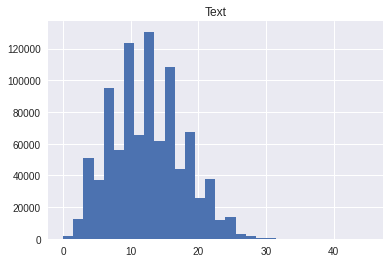

In [ ]:
import matplotlib.pyplot as plt
test_review_word_count = []

# populate the lists with sentence lengths
for review in reviews['Text'].values:
      test_review_word_count.append(len(review.split()))

length_df = pd.DataFrame({'Text':test_review_word_count})

length_df.hist(bins = 30)
plt.show()

#### Baseline Model with GloVe

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model.add(LSTM(300, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_,
    #validation_data=(test_padded, test_labels),
    verbose=1,
)

Epoch 1/20
10382/10382 [==============================] - 104s 9ms/step - loss: 0.4619 - accuracy: 0.7771 - val_loss: 0.4184 - val_accuracy: 0.8042
Epoch 2/20
10382/10382 [==============================] - 98s 9ms/step - loss: 0.4079 - accuracy: 0.8105 - val_loss: 0.3999 - val_accuracy: 0.8175
Epoch 3/20
10382/10382 [==============================] - 98s 9ms/step - loss: 0.3810 - accuracy: 0.8267 - val_loss: 0.3800 - val_accuracy: 0.8265
Epoch 4/20
10382/10382 [==============================] - 97s 9ms/step - loss: 0.3604 - accuracy: 0.8377 - val_loss: 0.3803 - val_accuracy: 0.8285
Epoch 5/20
10382/10382 [==============================] - 98s 9ms/step - loss: 0.3413 - accuracy: 0.8480 - val_loss: 0.3758 - val_accuracy: 0.8322
Epoch 6/20
10382/10382 [==============================] - 98s 9ms/step - loss: 0.3230 - accuracy: 0.8574 - val_loss: 0.3787 - val_accuracy: 0.8294
Epoch 7/20
10382/10382 [==============================] - 97s 9ms/step - loss: 0.3050 - accuracy: 0.8671 - val_loss: 

In [ ]:
'''history = model.fit(
    train_padded,
    train_labels,
    epochs=20,
    validation_data=(test_padded, test_labels),
    verbose=1,
)'''

In [ ]:
X_train

,Text
796377,crossdressing lead hissable villain oodles dou...
970672,dalsgaards advocacy gehls utopian vision large...
222744,gains huge points working standalone movie set...
608786,sadly could next tiny furniture gets wrapped n...
521067,antideath penalty nature film lauded lacks imp...
...,...
280317,comedy favors mania wit requires high toleranc...
393908,film endures largely appeal story line cast
144874,part response stanley kubricks heady masterpie...
776804,heart humour countdown armageddon


In [ ]:
reviews['Text']

0          fantasy adventure fuses greek mythology contem...
1          uma thurman medusa gorgon coiffure writhing sn...
2          topnotch cast dazzling special effects tide te...
3          whether audiences get behind lightning thief h...
4          whats really lacking lightning thief genuine s...
                                 ...                        
1130008      rousing reconstruction 1879 battle rorkes drift
1130013    seen today startling indictment british imperi...
1130014    rousing visual spectacle thats prequel cy endf...
1130015    simple twoact story prelude war war former con...
1130016    rides line pure artifact bygone eraone depicts...
Name: Text, Length: 949181, dtype: object

In [ ]:
sentences = reviews['Text']

In [ ]:
#sequences = tokenizer.texts_to_sequences(test.text)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [ ]:
padded[0:5]

array([[   323,    245,  13116,   3470,   2442,    754,    125,   1018,
          1218,    243,    158,   2859,    206,     92,    524,     96,
          1166,    196,    640,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0],
       [  2443,  12007,  31608,  60834,  55167,  20150,   7620, 153456,
          2817,   4277,      3,   3127,  10789,    323,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0],
       [  2870,     59,   1207,    223,    203,   7094,   1808,    315,
          1465

In [ ]:
pred = model.predict(padded[6:10])
pred_int = pred.round().astype("int")

In [ ]:
pred

array([[9.9429578e-01],
       [4.7660875e-04],
       [3.1818424e-03],
       [8.4199263e-03]], dtype=float32)

In [ ]:
pred_int

array([[1],
       [0],
       [0],
       [0]])

In [ ]:
reviews.iloc[6:10:,:]

,Text,Type
6,harry potter knockoffs dont come transparent s...,1
7,percy jackson isnt great movie good one trotti...,0
8,fun brisk imaginative,0
9,crammed dragons setdestroying fights things ex...,0


In [ ]:
sequences[5]

[1500, 2357, 78601, 27086, 275, 408, 1027]

In [ ]:
reviews.iloc[5,:]

Text    list ingredients moviemagic potion enjoy start...
Type                                                    1
Name: 5, dtype: object

In [ ]:
padded[6]

array([ 1465,  1774, 15262,    67,   108,  6711,  5146,   296,  1392,
        9323,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
model.predict(padded[6].reshape(1, -1))

array([[0.9942958]], dtype=float32)

Check inverse

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

In [ ]:
decode(sequences[5])

'list ingredients moviemagic potion enjoy start finish'

In [ ]:
reviews.head(10)

,Text,Type
0,fantasy adventure fuses greek mythology contem...,0
1,uma thurman medusa gorgon coiffure writhing sn...,0
2,topnotch cast dazzling special effects tide te...,0
3,whether audiences get behind lightning thief h...,0
4,whats really lacking lightning thief genuine s...,1
5,list ingredients moviemagic potion enjoy start...,1
6,harry potter knockoffs dont come transparent s...,1
7,percy jackson isnt great movie good one trotti...,0
8,fun brisk imaginative,0
9,crammed dragons setdestroying fights things ex...,0


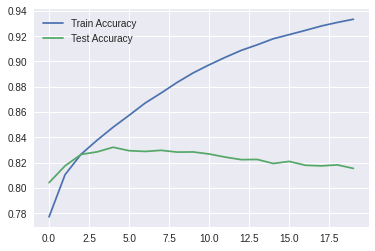

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

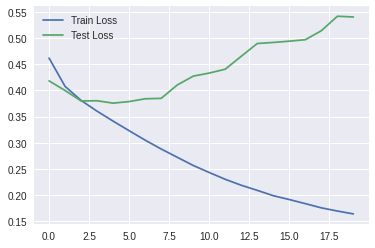

In [ ]:
plt.plot(history.history['loss'], label='Train Loss') 
plt.plot(history.history['val_loss'], label='Test Loss') 
plt.legend() 
plt.show()

In [ ]:
test

NameError: ignored

In [ ]:
import pickle

In [ ]:
# Save the trained model as a pickle string.
#saved_model = pickle.dumps(history)

In [ ]:
type(history)

NameError: ignored

In [ ]:
model

NameError: ignored

In [ ]:
# save the knn_model to disk
filename = 'Trained_Model_1.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://30ef5f0d-5709-4de5-82a8-54a2dd56630a/assets


INFO:tensorflow:Assets written to: ram://30ef5f0d-5709-4de5-82a8-54a2dd56630a/assets


In [ ]:
# load the model from disk
#filename = 'Our_Trained_knn_model.sav'
trained_model_reloaded = pickle.load(open(filename, 'rb'))



In [ ]:
 
# Load the pickled model
knn_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
knn_from_pickle.predict(X_test)